In [1]:
! git clone https://github.com/gcode-ai/vllm.git

Cloning into 'vllm'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 77 (delta 14), reused 76 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 5.09 MiB | 25.44 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
import os
os.chdir(f'./vllm')


In [6]:
! pip install wget captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00


In [7]:
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering
from lxmert.lxmert.src.lxmert_lrp import LxmertForQuestionAnswering as LxmertForQuestionAnsweringLRP
from tqdm import tqdm
from lxmert.lxmert.src.ExplanationGenerator import GeneratorOurs, GeneratorBaselines, GeneratorOursAblationNoAggregation
import random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from captum.attr import visualization
import requests

In [8]:
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

In [9]:
class ModelUsage:
    def __init__(self, use_lrp=False):
        self.vqa_answers = utils.get_data(VQA_URL)

        # load models and model components
        self.frcnn_cfg = utils.Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        self.frcnn_cfg.MODEL.DEVICE = "cuda"

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=self.frcnn_cfg)

        self.image_preprocess = Preprocess(self.frcnn_cfg)

        self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

        if use_lrp:
            self.lxmert_vqa = LxmertForQuestionAnsweringLRP.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")
        else:
            self.lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")

        self.lxmert_vqa.eval()
        self.model = self.lxmert_vqa

        # self.vqa_dataset = vqa_data.VQADataset(splits="valid")

    def forward(self, item):
        URL, question = item

        self.image_file_path = URL

        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(URL)
        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections= self.frcnn_cfg.max_detections,
            return_tensors="pt"
        )
        inputs = self.lxmert_tokenizer(
            question,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        self.question_tokens = self.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids.flatten())
        self.text_len = len(self.question_tokens)
        # Very important that the boxes are normalized
        normalized_boxes = output_dict.get("normalized_boxes")
        features = output_dict.get("roi_features")
        self.image_boxes_len = features.shape[1]
        self.bboxes = output_dict.get("boxes")
        self.output = self.lxmert_vqa(
            input_ids=inputs.input_ids.to("cuda"),
            attention_mask=inputs.attention_mask.to("cuda"),
            visual_feats=features.to("cuda"),
            visual_pos=normalized_boxes.to("cuda"),
            token_type_ids=inputs.token_type_ids.to("cuda"),
            return_dict=True,
            output_attentions=False,
        )
        return self.output

In [10]:
def save_image_vis(image_file_path, bbox_scores):
    bbox_scores = image_scores
    _, top_bboxes_indices = bbox_scores.topk(k=1, dim=-1)
    img = cv2.imread(image_file_path)
    mask = torch.zeros(img.shape[0], img.shape[1])
    for index in range(len(bbox_scores)):
        [x, y, w, h] = model_lrp.bboxes[0][index]
        curr_score_tensor = mask[int(y):int(h), int(x):int(w)]
        new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
        mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img = img * mask.cpu().data.numpy()
    cv2.imwrite(
            'lxmert/lxmert/experiments/paper/new.jpg', img)

In [17]:
model_lrp = ModelUsage(use_lrp=True)
lrp = GeneratorOurs(model_lrp)
baselines = GeneratorBaselines(model_lrp)
vqa_answers = utils.get_data(VQA_URL)

# baselines.generate_transformer_attr(None)
# baselines.generate_attn_gradcam(None)
# baselines.generate_partial_lrp(None)
# baselines.generate_raw_attn(None)
# baselines.generate_rollout(None)

image_ids = [
    # giraffe
    'COCO_val2014_000000185590',
    # baseball
    'COCO_val2014_000000127510',
    # bath
    'COCO_val2014_000000324266',
    # frisbee
    'COCO_val2014_000000200717'
]

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0


/content/vllm/lxmert/lxmert/src/modeling_frcnn.py:1755: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map_location="cpu")


All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [33]:
test_questions_for_images = [
    "What room is shown in the image?",
    "Is the wall damaged?",
    "What type of material is the wall (ceramic tile, drywall, concrete, metal, wood)?",
]

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,[CLS] what room is shown in the image ? [SEP]


ANSWER: bathroom


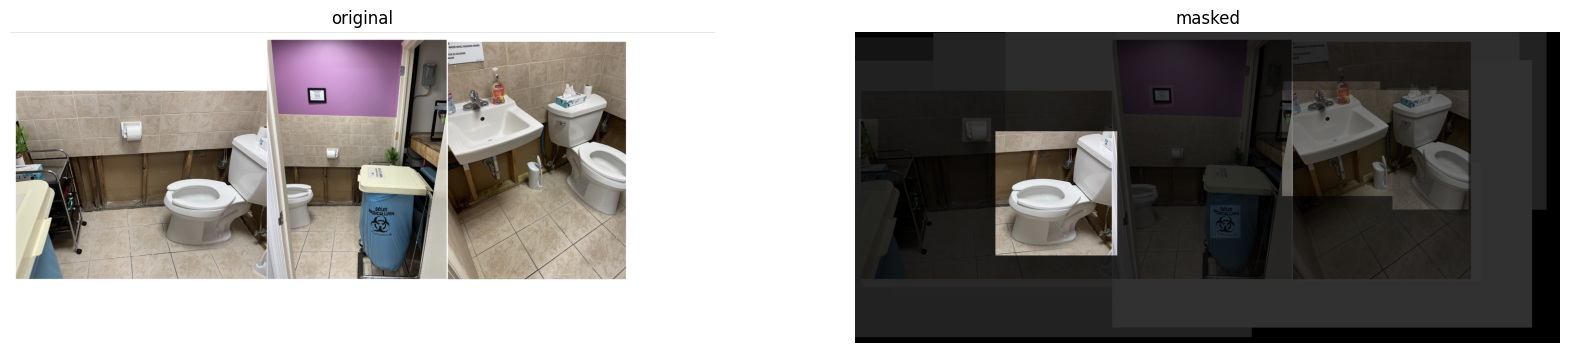

In [27]:
URL = '/content/bathroom.png'
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[0]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,[CLS] is the wall damaged ? [SEP]


ANSWER: yes


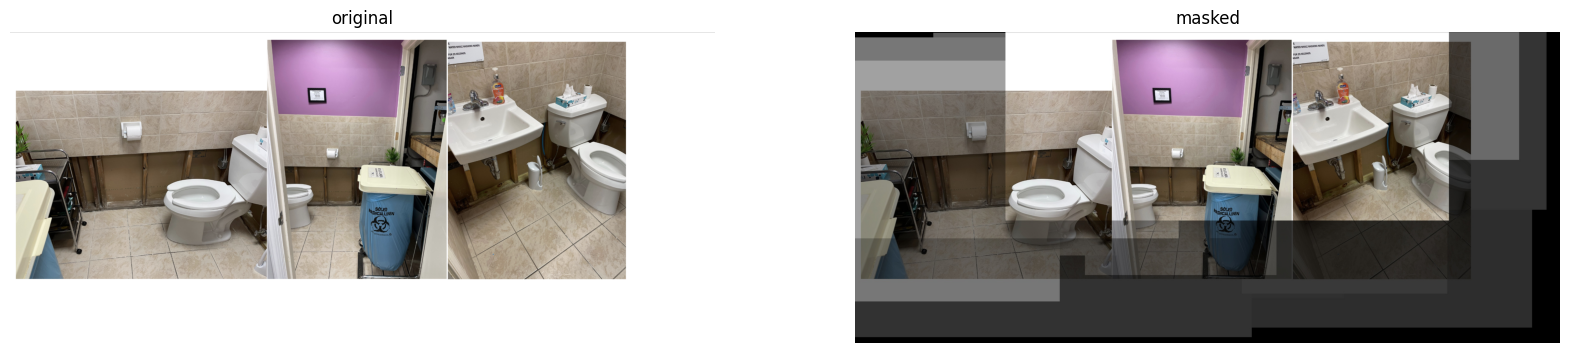

In [30]:
URL = '/content/bathroom.png'
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[1]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,"[CLS] what type of material is the wall ( ceramic tile , dry ##wall , concrete , metal , wood ) ? [SEP]"


ANSWER: marble


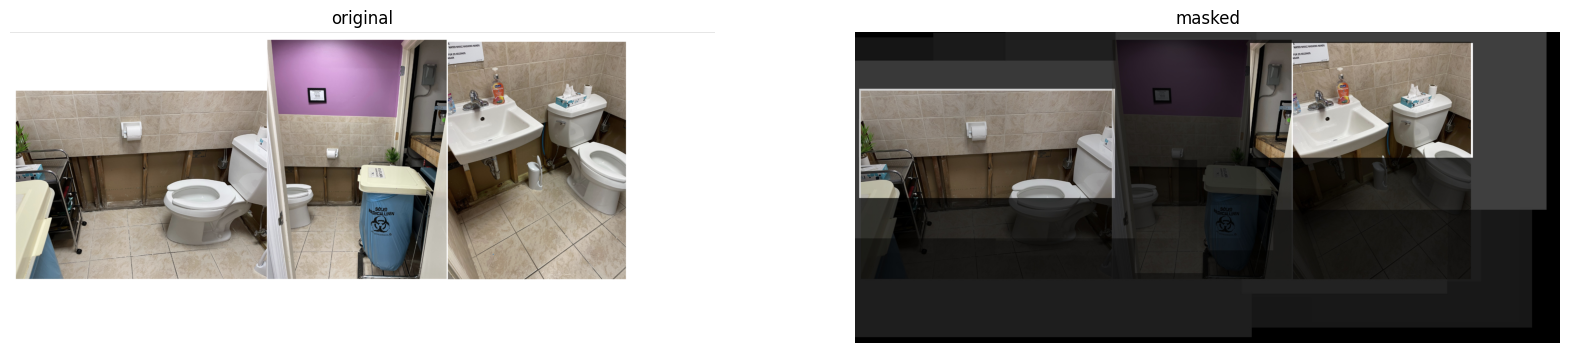

In [34]:
URL = '/content/bathroom.png'
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[2]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])